In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolor
from matplotlib.ticker import FormatStrFormatter
import sys
sys.path.append("/Volumes/pdoubraw-1/repos/")
# sys.path.append("C:/Users/krydalch/Documents/Repos/")
from datatools import wfip2
from datatools.remote_sensing import scintec_profiler

In [4]:
fs = 18
plt.rc("font",size=fs)

# read in the sodar data

In [6]:
sodar_path = "/Volumes/pdoubraw-1/repos/jet/data/"
# sodar_path = "C:\\Users\\krydalch\\Desktop\\MetMastData\\SODAR\\"

df = wfip2.read_dir(dpath=sodar_path, reader=scintec_profiler, ext='mnd')
df = df.set_index("datetime")
# Remove Faulty Data
df = df.replace("99.99",np.nan)
df = df.replace("999.9",np.nan)

df['wind speed'] = df['wind speed'].astype(float)



In [7]:
time_vs_height = df[["wind speed","height"]].reset_index().set_index(["datetime","height"]).unstack().astype("float")
time_vs_height.index = time_vs_height.index.tz_localize("UTC")

# read in the sonic data

In [20]:
df_sonic = pd.read_csv("sonic_ws_10min_mean.csv",index_col=[0],parse_dates=True)
df_sonic.index.name = "datetime"
df_sonic.columns = [float(s) for s in df_sonic.columns]

# some parameters

In [21]:
zhubs = {'V27':32.1, '1.5 MW':84.0, '5 MW':90.0,  '10 MW':119.0}
Ds    = {'V27':27.0, '1.5 MW':70.0, '5 MW':126.0, '10 MW':178.3}
xloc  = {'V27':100.0, '1.5 MW':115.0, '5 MW':130.0, '10 MW':145.0}
tilt_angle = np.radians(4)

In [8]:
time_index_mixed = 111
time_index_jet = 61

# plot heat map

In [9]:
vmin = 5
vmax = 25

mi_sodar = df['wind speed'].min()
ma_sodar = df['wind speed'].max()
print("max and min Sodar::")
print(mi_sodar)
print(ma_sodar)


mi_sonic = (df_sonic.min()).min()
ma_sonic = (df_sonic.max()).max()
print("max and min Sonic::")
print(mi_sonic)
print(ma_sonic)



max and min Sodar::
3.26
22.94
max and min Sonic::
0.8136329529720554
28.217127242954106


<class 'matplotlib.colors.Normalize'>


Text(2017-02-17 07:40:00+00:00, 268, 'LLJ REGION')

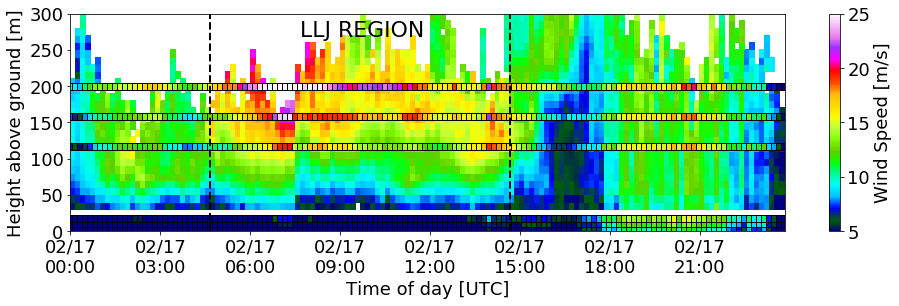

In [14]:
norm = mcolor.Normalize(vmin=vmin,vmax=vmax)

print(type(norm))
fig  = plt.figure(figsize=(16,4))
ax   = fig.add_subplot(111)



wslevels = np.arange(vmin,vmax+.01,2)

sodar_contour = ax.pcolormesh(time_vs_height.index,
                              np.unique(df.height),
                              time_vs_height.T.values, vmin=vmin, vmax=vmax, norm=norm, cmap=plt.cm.gist_ncar)


sonic_z    = [np.float(z) for z in df_sonic.columns]
sonic_t    = df_sonic.index
[sz,st]    = np.meshgrid(sonic_z, sonic_t)
sonic_dots = ax.scatter(st, sz, c=df_sonic.values, norm = norm, vmin=vmin, vmax=vmax, cmap=plt.cm.gist_ncar, edgecolors='k',s=50, marker='s')

sm = plt.cm.ScalarMappable(cmap=plt.cm.gist_ncar, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ticks=np.arange(5,vmax+0.1,5),  #np.arange(5,vmax+0.1,2)
                    label='Wind Speed [m/s]')

# # sanity check, two colorbars
# plt.colorbar(sonic_dots)
# plt.colorbar(sodar_contour)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))   

ax.set_xlabel("Time of day [UTC]")
ax.set_ylabel("Height above ground [m]")
ax.set_ylim([0,300])
ax.set_xlim([time_vs_height.index[0], time_vs_height.index[-1]])
# ax.legend(("blues", "agh"))
plt.axvline(x='2017-02-17 04:40:00+00:00',linewidth=2, color='k',linestyle='--')
plt.axvline(x='2017-02-17 14:40:00+00:00',linewidth=2, color='k',linestyle='--')
plt.text('2017-02-17 07:40:00+00:00', 268, 'LLJ REGION', fontsize=22)
#fig.savefig("../SODAR_jet_mixed1.png",bbox_inches="tight",dpi=500)

# plot profiles

In [ ]:
colors = ["#D5D8DC",
          "#ABB2B9",
          "#808B96",
          "#566573",
          "#2C3E50",
          "k"]

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


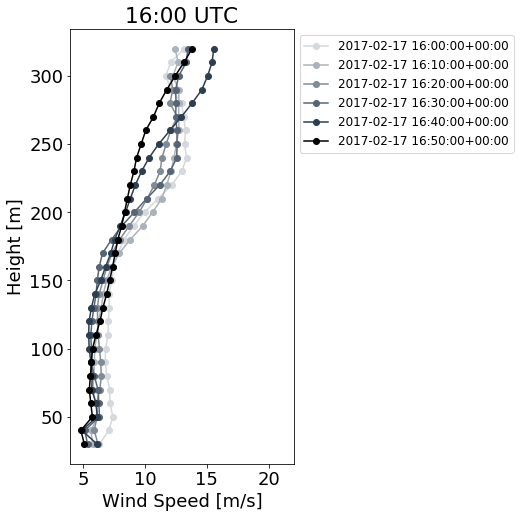

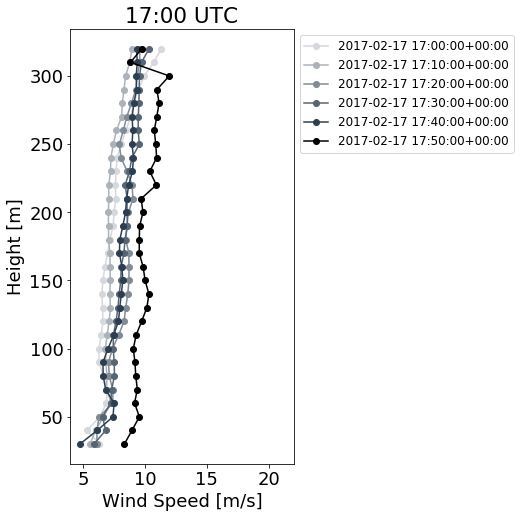

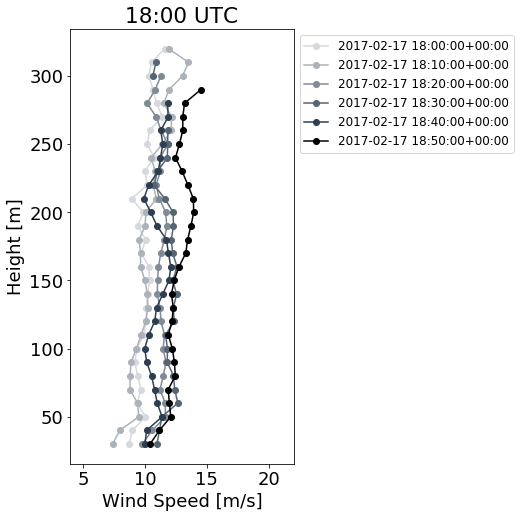

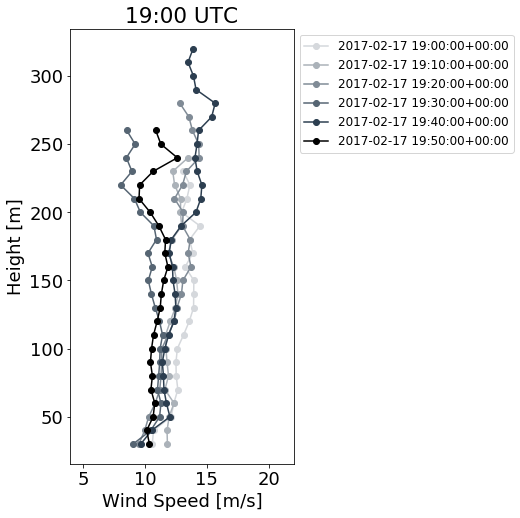

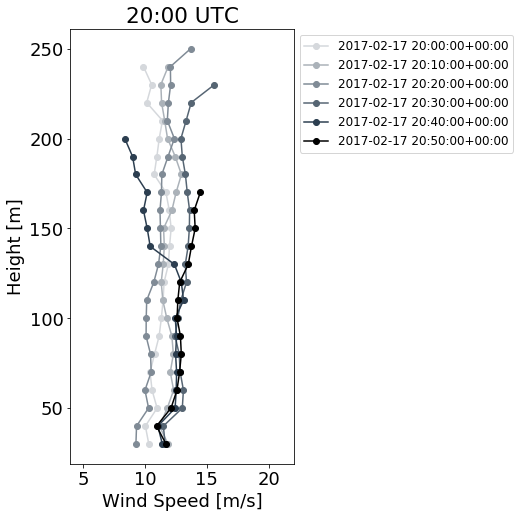

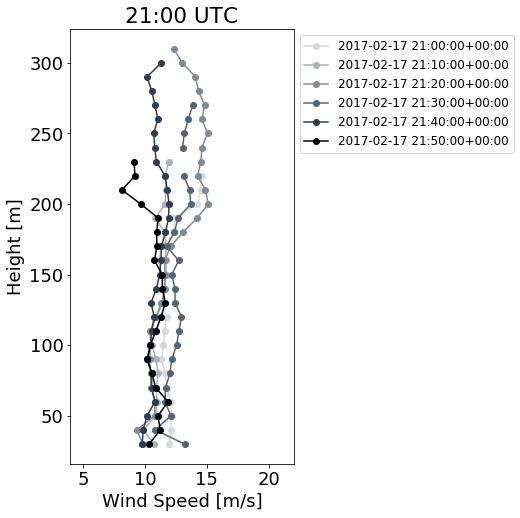

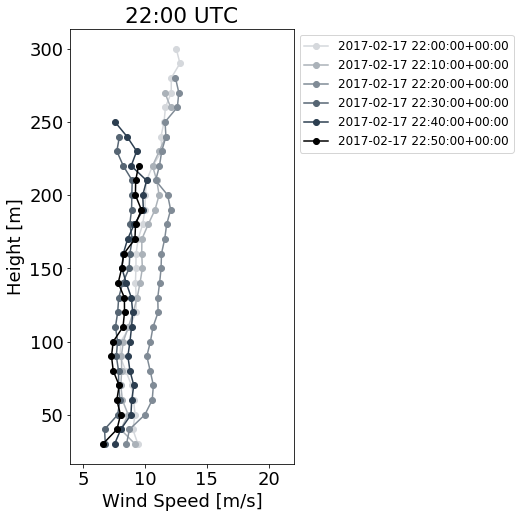

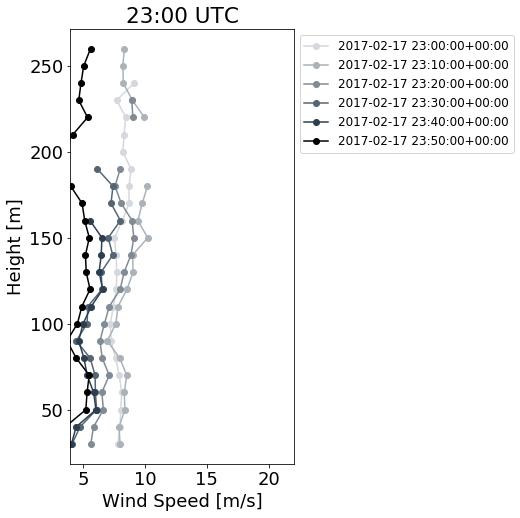

In [72]:
for hour in np.arange(16,24,1):
    start = pd.Timestamp(2017,2,17,hour,0)
    end   = pd.Timestamp(2017,2,17,hour,59)
    times = pd.DatetimeIndex(start=start,end=end,freq='10min',name='datetime').tz_localize('UTC')

    fig = plt.figure(figsize=(4,8))
    ax  = fig.add_subplot(111)

    i = 0
    for idx in times:
        profile = time_vs_height.loc[idx]
        z       = profile.index.get_level_values(1)
        u       = profile.values
        ax.plot(u,z,'o-',label=idx,color=colors[i])
        i += 1

    plt.legend(bbox_to_anchor=(1,1),fontsize=12)

    ax.set_xlabel("Wind Speed [m/s]")
    ax.set_ylabel("Height [m]")
    ax.set_title("{0:02d}:00 UTC".format(hour))
    ax.set_xlim([4,22])
    ax.set_xticks([5,10,15,20])
    fig.savefig("/Volumes/pdoubraw-1/repos/jet/figs/sodar_profiles_hour{0}.png".format(hour),dpi=300,bbox_inches="tight")

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """


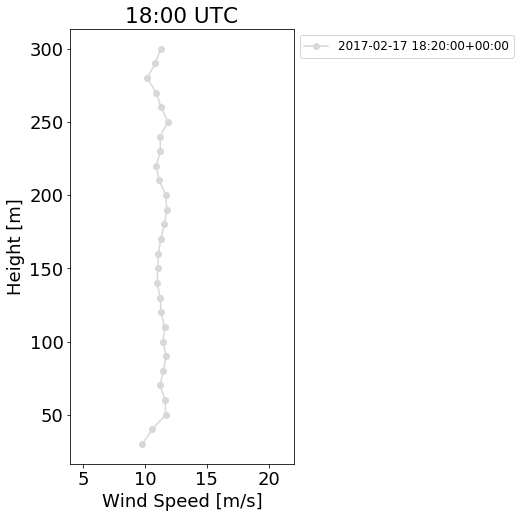

In [73]:
hour = 18

start = pd.Timestamp(2017,2,17,hour,20)
end   = pd.Timestamp(2017,2,17,hour,29)
times = pd.DatetimeIndex(start=start,end=end,freq='10min',name='datetime').tz_localize('UTC')

fig = plt.figure(figsize=(4,8))
ax  = fig.add_subplot(111)

i = 0
for idx in times:
    profile = time_vs_height.loc[idx]
    z       = profile.index.get_level_values(1)
    u       = profile.values
    ax.plot(u,z,'o-',label=idx,color=colors[i])
    i += 1

plt.legend(bbox_to_anchor=(1,1),fontsize=12)

ax.set_xlabel("Wind Speed [m/s]")
ax.set_ylabel("Height [m]")
ax.set_title("{0:02d}:00 UTC".format(hour))
ax.set_xlim([4,22])
ax.set_xticks([5,10,15,20])

In [74]:
u_nona = u[~np.isnan(u)]
z_nona = z[~np.isnan(u)]

# time series

In [13]:
height = 160

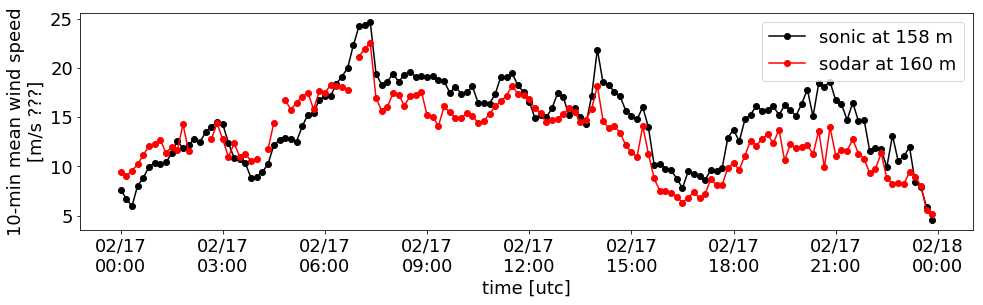

In [14]:
fig  = plt.figure(figsize=(16,4))
ax   = fig.add_subplot(111)

col = df_sonic.columns[np.argmin(np.abs(df_sonic.columns - height))]
ax.plot(df_sonic[col],'-ok',label="sonic at {0:.0f} m".format(col))

#ax.plot(df_sonic[col]/0.44704,'-oc',label="sonic at {0:.0f} m (scaled)".format(col))

sodar = df[df.height==height]["wind speed"].astype("float").copy()
sodar[sodar>90.0] = np.nan

ax.plot(sodar,'-or',label="sodar at {0:.0f} m".format(height))

ax.set_ylabel("10-min mean wind speed\n[m/s ???]")
ax.set_xlabel("time [utc]")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M')) 


plt.legend()